<a href="https://colab.research.google.com/github/GitHub-Aditya14Raj/PRODIGY_GAI_05/blob/main/Task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess images
def load_and_process_img(path):
    img = load_img(path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

content_path = '/content/OIP (2).jpeg'
style_path = '/content/pattern.jpg'

content_image = load_and_process_img(content_path)
style_image = load_and_process_img(style_path)
generated_image = tf.Variable(content_image)

# Load pre-trained VGG19 model
model = vgg19.VGG19(weights='imagenet', include_top=False)

# Content layer
content_layer = 'block5_conv2'

# Style layers
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

# Extract features
def get_features(image, model):
    outputs = [model.get_layer(layer).output for layer in style_layers + [content_layer]]
    features = tf.keras.Model(inputs=model.inputs, outputs=outputs)(image)
    return features

# Compute gram matrix
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

# Define loss functions
def style_loss(style_features, generated_features):
    loss = tf.add_n([tf.reduce_mean((gram_matrix(style) - gram_matrix(generated))**2)
                     for style, generated in zip(style_features, generated_features)])
    return loss / len(style_layers)

def content_loss(content_features, generated_features):
    return tf.reduce_mean((content_features - generated_features)**2)

def total_variation_loss(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))

# Optimization step
@tf.function
def train_step(content_features, style_features, generated_image):
    with tf.GradientTape() as tape:
        generated_features = get_features(generated_image, model)
        c_loss = content_loss(content_features[-1], generated_features[-1])
        s_loss = style_loss(style_features[:-1], generated_features[:-1])
        tv_loss = total_variation_loss(generated_image)
        total_loss = c_loss + s_loss * 1e4 + tv_loss * 30

    grads = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(grads, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 255.0))

# Extract features
content_features = get_features(content_image, model)
style_features = get_features(style_image, model)

# Optimization
optimizer = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
epochs = 1000

for epoch in range(epochs):
    train_step(content_features, style_features, generated_image)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}")

# Save the result
result = generated_image.numpy()
result = result.reshape((224, 224, 3))
result = np.clip(result, 0, 255).astype('uint8')
tf.keras.preprocessing.image.save_img("generated_image.jpg", result)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


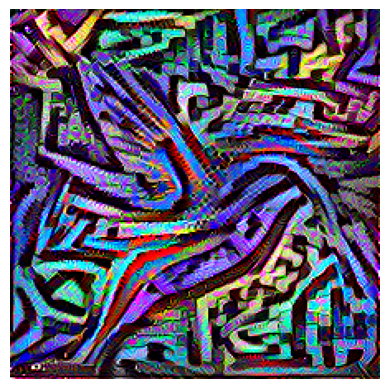

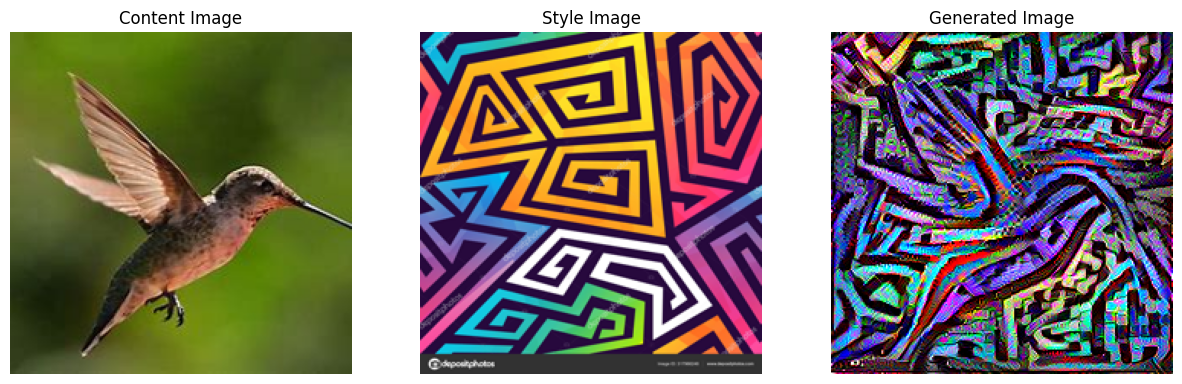

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
# Convert to image
result = generated_image.numpy()
result = result.reshape((224, 224, 3))
result = np.clip(result, 0, 255).astype('uint8')

# Save the result
tf.keras.preprocessing.image.save_img("generated_image.jpg", result)

# Display the result
plt.imshow(result)
plt.axis('off')
plt.show()

# Also display the original content and style images for comparison
content = Image.open(content_path).resize((224, 224))
style = Image.open(style_path).resize((224, 224))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(content)
ax1.set_title('Content Image')
ax1.axis('off')
ax2.imshow(style)
ax2.set_title('Style Image')
ax2.axis('off')
ax3.imshow(result)
ax3.set_title('Generated Image')
ax3.axis('off')
plt.show()